# Interpolação dos Dados Censitários por Município, Sexo e Idade

## Preparação do Notebook

Na célula adiante são feitos procedimentos de preparação do notebook para trabalho com os dados, tais como:
1. mapeamento do diretório em que se encontra o pacote br_demography;
2. importação de bibliotecas necessárias para processamento dos dados;
3. carregametno de project_id para faturamento no Google Cloud, conforme requerido pela biblioteca basedosdados.

In [2]:
# adicionando br_demography to Python Path
import sys 
sys.path.append("../../")

# carregamento de bibliotecas para processamento dos dados
from br_demography  import municipality_migration as mm
from br_demography  import municipality_births as mb
from br_demography  import municipality_pop_pyramid as mpp
import matplotlib.pyplot as plt
import basedosdados as bd
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np

# Carregando as variáveis de ambiente do arquivo .env
load_dotenv(dotenv_path='../../.env')

# Carregando o project_id para faturamento no Google Cloud
project_id = os.getenv('GOOGLE_CLOUD_PROJECT_ID')

## Carregamento dos dados, interpolação e salvamento dos resultados

Adiante são realizados os seguintes procedimentos:

1. é carregado arquivo cod_mun.csv, com os municípios de interesse;
2. para cada município, são feitos downloads de microdados da população por sexo e idade, nos censos 2000, 2010 e 2022;
3. os dados são tratados (padronização de faixas etárias decenais, indexação, inserção de valor "0" para coortes com valor nulo, padronização de tipagem, etc.);
4. Concatenaçao dos dados tratados de 2000, 2010 e 2022 em um único DataFrame, df_age_pyramid;
5. São calculadas as taxas de crescimento populacional 2000-2010 e 2010-2022, inseridas no  DataFrame df_taxa_crecimento_pop;
6. A população de cada coorte, para cada ano, em cada município, é calculada conforme a taxa de crescimento intercensitária;
7. Tratamentos finais são realizados no DataFrame df_age_pyramid (novas colunas, agrupamento dos dados, imputação de valores em caso de NULL, indexação);
8. Concatenação dos dados finais no DataFrame df;
9. salvamento dos resultados em pop_municipios_rmc_2000_2022_estimativa_intercensitaria.csv



In [3]:
# Carregamento de arquivo CSV com rol de municípios de Interesse
df_mun = pd.read_csv('../../br_demography/source/tab/cod_mun.csv', sep=';', index_col='mun_id')

# geração de dicionário que receberá cada dataframe com dados para cada município
dict_dfs = dict()

# loop de iteração para obtenção e tratamento de dados de município constante no dataframe df_mun
for mun_id, mun in df_mun.itertuples():

    #download de microdados de população por sexo e idade nos censos 2000, 2010 e 2022
    df_age_pyramid_2022 = mpp.query_total_pop_by_sex_age_2022(mun_id=mun_id, project_id=project_id)
    df_age_pyramid_2010 = mpp.query_total_pop_by_sex_age_2010(mun_id=mun_id, project_id=project_id)
    df_age_pyramid_2000 = mpp.query_total_pop_by_sex_age_2000(mun_id=mun_id, project_id=project_id)

    #tratamento dos microdados
    df_age_pyramid_2022 = mpp.standard_age_groups(df=df_age_pyramid_2022, age_group_csv_path='../../br_demography/source/tab/faixas_etarias_censo_2022.csv', year=2022)
    df_age_pyramid_2010 = mpp.standard_age_groups(df=df_age_pyramid_2010, age_group_csv_path='../../br_demography/source/tab/faixas_etarias_censo_2000_2010.csv', year=2010)
    df_age_pyramid_2000 = mpp.standard_age_groups(df=df_age_pyramid_2000, age_group_csv_path='../../br_demography/source/tab/faixas_etarias_censo_2000_2010.csv', year=2000)

    #Concatenação dos dados tratados em um único DataFrame
    df_age_pyramid = mpp.concatenate_treated_dfs(dfs=[df_age_pyramid_2022, df_age_pyramid_2010, df_age_pyramid_2000])

    # Criação do DataFrame df_taxa_crecimento_pop
    df_taxa_crecimento_pop = pd.DataFrame()

    # Cálculo de taxa de crescimento geométrico anual para cada período intercensitário, para o município sob iteração
    df_taxa_crecimento_pop['2000 a 2010'] = (df_age_pyramid[2010] / df_age_pyramid[2000])**(1/(2010-2000)) - 1
    df_taxa_crecimento_pop['2010 a 2022'] = (df_age_pyramid[2022] / df_age_pyramid[2010])**(1/(2022-2010)) - 1

    # Iteração a partir das taxas de crescimento e estimativa da população para cada faixa etária e sexo por ano intercensitário
    for taxa in df_taxa_crecimento_pop.columns:
        #seleção dos anos iniciais e finais para interpolação
        ano_inicial, ano_final = [int(ano.strip()) for ano in taxa.split('a')]    
        #Iteração para cálculo de população para cada ano no período entre os anos inicial e final
        for ano in range(ano_inicial, ano_final):
            #cálculo da população e inserção dos dados em novas colunas do DataFrame df_age_pyramid
            df_age_pyramid[ano] = (df_age_pyramid[ano_inicial]*((1+ df_taxa_crecimento_pop[taxa])**(ano-ano_inicial))) #.astype(int)
    # reorganização da ordem das colunas, de 1996 a 2022 no DataFrame
    df_age_pyramid = df_age_pyramid[range(df_age_pyramid.columns.min(), df_age_pyramid.columns.max()+1)]

    # inserção de valor 0 quando não houver população em determinada faixa etária
    df_age_pyramid = df_age_pyramid.fillna(0).astype(int)

    #Inserção da coluna município em df_age_pyramid, com registro do município da iteração 
    df_age_pyramid['Município'] = mun

    #Estabelecimento de index
    df_age_pyramid = df_age_pyramid.reset_index().set_index(['Município', 'Sexo', 'Faixa Etária'])

    # atribuição do DataFrame df_age_pyramid de cada município, a sua chave no dicionário dict_dfs 
    dict_dfs[mun] = df_age_pyramid

# concatenaçao de todos os DataFrames constanntes no dicionário dict_dfs
df = pd.concat(objs=dict_dfs.values())

# salvamento dos dados resultantes em arquivo csv
df.to_csv(path_or_buf='../../br_demography/results/tab/pop_municipios_rmc_2000_2022_estimativa_intercensitaria.csv', sep=';', decimal=',')


Downloading: 100%|██████████| 157/157 [00:00<00:00, 436.34rows/s]


In [5]:
df

2000  2001  2002  2003  2004  2005  \
Município      Sexo      Faixa Etária                                          
Adrianópolis   Feminino  0 a 9 anos        704   681   660   639   619   599   
                         10 a 19 anos      823   798   775   752   730   708   
                         20 a 29 anos      437   435   434   433   431   430   
                         30 a 39 anos      439   432   426   420   413   407   
                         40 a 49 anos      338   343   348   353   359   364   
...                                        ...   ...   ...   ...   ...   ...   
Doutor Ulysses Masculino 40 a 49 anos      324   326   329   333   336   339   
                         50 a 59 anos      202   206   210   215   219   224   
                         60 a 69 anos      158   159   160   161   163   164   
                         70 a 79 anos       79    79    80    81    82    83   
                         80 anos ou mais    22    23    24    26    28    30   

                                          2006  2007  2008  2009  ...  2013  \
Município      Sexo      Faixa Etária                             ...         
Adrianópolis   Feminino  0 a 9 anos        580   562   544   527  ...   485   
                         10 a 19 anos      687   667   647   628  ...   576   
                         20 a 29 anos      429   427   426   425  ...   413   
                         30 a 39 anos      401   396   390   384  ...   384   
                         40 a 49 anos      370   376   382   388  ...   395   
...                                        ...   ...   ...   ...  ...   ...   
Doutor Ulysses Masculino 40 a 49 anos      342   345   348   351  ...   373   
                         50 a 59 anos      229   233   238   243  ...   280   
                         60 a 69 anos      165   166   168   169  ...   189   
                         70 a 79 anos       84    85    86    87  ...   100   
                         80 anos ou mais    31    34    36    38  ...    46   

                                          2014  2015  2016  2017  2018  2019  \
Município      Sexo      Faixa Etária                                          
Adrianópolis   Feminino  0 a 9 anos        476   468   460   452   444   437   
                         10 a 19 anos      565   555   545   534   524   515   
                         20 a 29 anos      410   406   403   400   396   393   
                         30 a 39 anos      385   387   389   391   392   394   
                         40 a 49 anos      396   397   397   398   399   399   
...                                        ...   ...   ...   ...   ...   ...   
Doutor Ulysses Masculino 40 a 49 anos      379   385   392   398   405   412   
                         50 a 59 anos      291   303   315   327   340   354   
                         60 a 69 anos      196   203   210   217   225   233   
                         70 a 79 anos      104   108   112   117   122   127   
                         80 anos ou mais    48    49    52    54    56    58   

                                          2020  2021  2022  
Município      Sexo      Faixa Etária                       
Adrianópolis   Feminino  0 a 9 anos        429   422   415  
                         10 a 19 anos      505   496   487  
                         20 a 29 anos      390   387   384  
                         30 a 39 anos      396   398   400  
                         40 a 49 anos      400   401   402  
...                                        ...   ...   ...  
Doutor Ulysses Masculino 40 a 49 anos      418   425   433  
                         50 a 59 anos      368   383   399  
                         60 a 69 anos      241   250   259  
                         70 a 79 anos      132   137   143  
                         80 anos ou mais    60    63    66  

[522 rows x 23 columns]

## Avaliação de Consistência

Para cada ano no intervalo entre 2000 e 2022, para coortes com mais de 25.000 pessoas no final do período, foram plotados os dados resultantes do processamento para avaliação de consistência. 

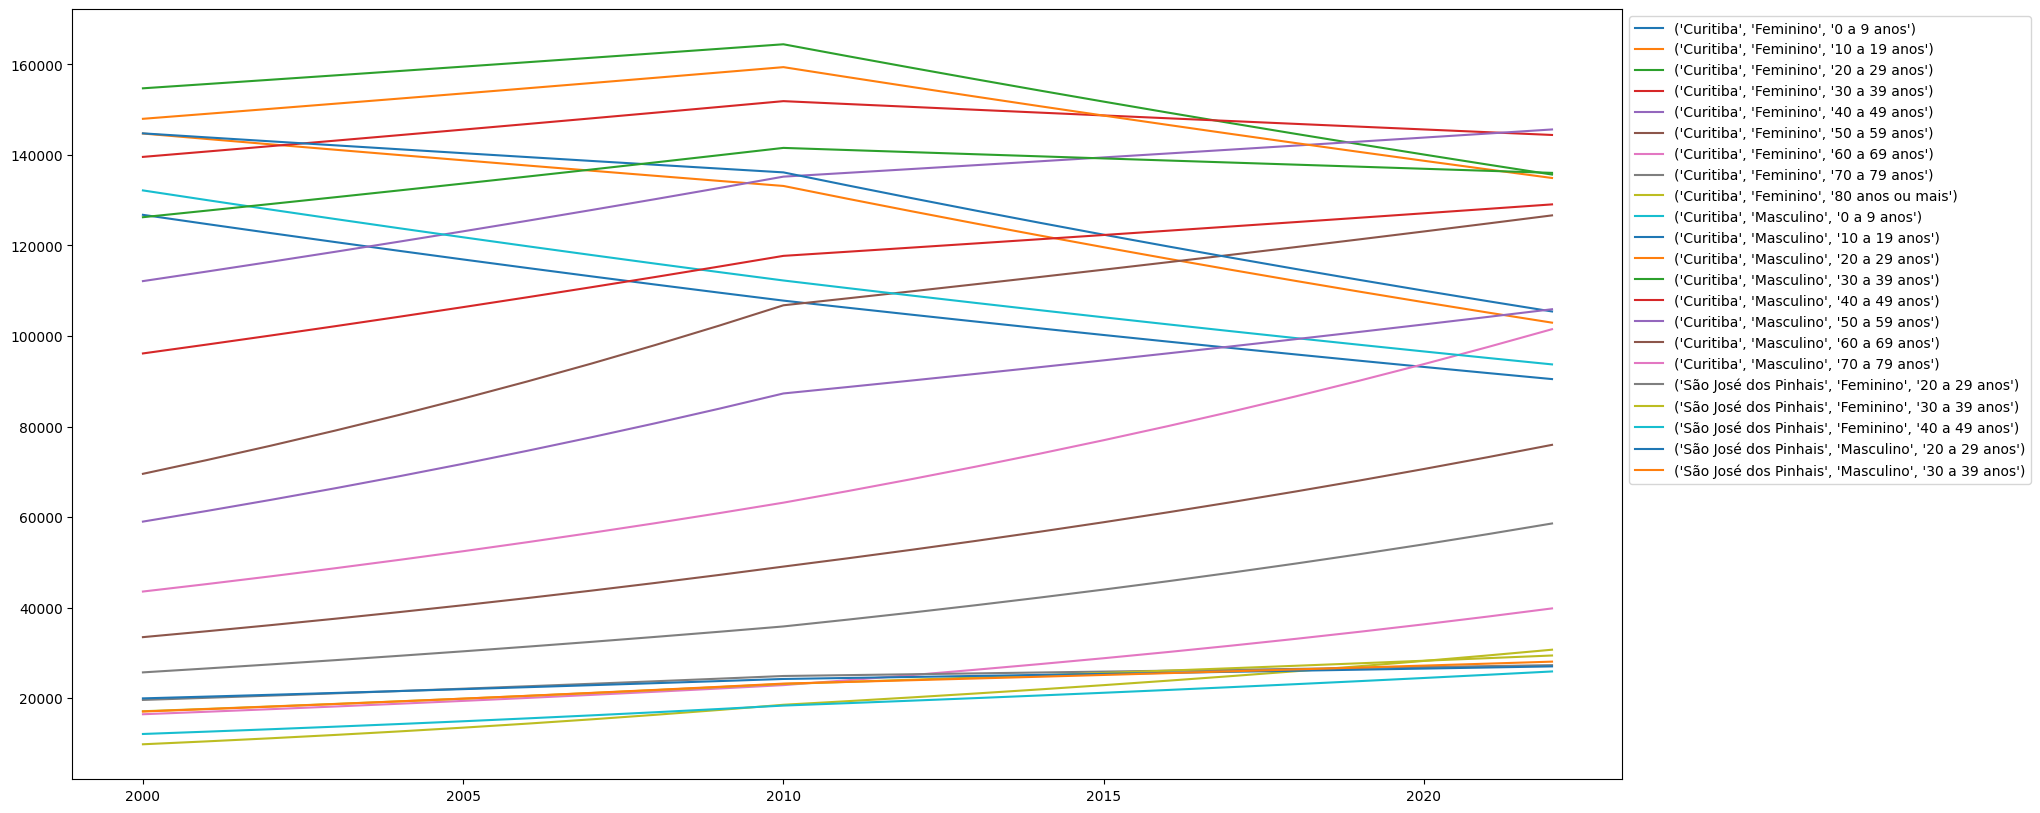

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
df[df[2022] > 25000].transpose().plot(ax=ax)
plt.legend(df[df[2022] > 25000].transpose().columns, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()